# Einops playground

- **Author**: Anier
- **Date**: March 11th, 2024

## Imports

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn

## Loading the dataset (CIFAR10 just as an example)

In [2]:
def display_image(image, axis = plt):
    assert image.shape[-1] == 3, "shape should be (H, W, 3) but got {}".format(image.shape)
    axis.imshow(image)

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


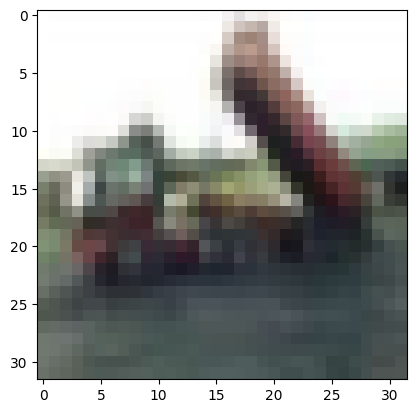

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)

image, label = cifar_dataset[2]

print(image.shape) # Channel, Height, Width
print(image.permute(1, 2, 0).shape) # Height, Width, Channel (as imshow expects)

display_image(image.permute(1, 2, 0))

## Experiments to showcase issues

In [4]:
height, width = 32, 32
batch_size = 4

In [5]:
dataloader = torch.utils.data.DataLoader(cifar_dataset, batch_size=batch_size, shuffle=True)

batch_X, batch_y = next(iter(dataloader))
batch_X = np.array(batch_X)
batch_X.shape

(4, 3, 32, 32)

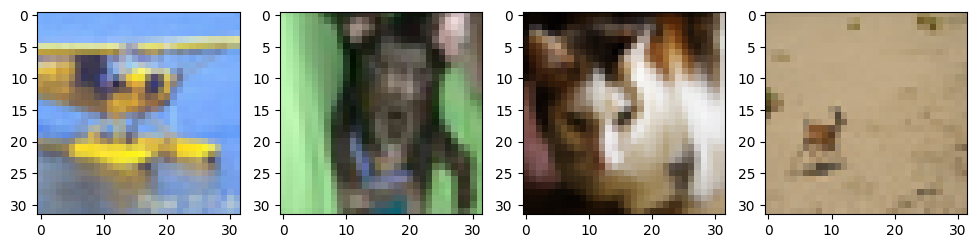

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for image, axis in zip(batch_X, axes):
    display_image(image.transpose(1, 2, 0), axis=axis)

plt.show()


**`batch_X` is a batch of 4 images of shape [3, 32, 32]**
**We want to plot the images in the same figure stacked**

**REMARK: the shape of a batch is `[batch_size, channel, height, width]`**

### Getting the right order of axis is hard

In [9]:
y1 = batch_X.transpose(2, 0, 3, 1).reshape(height, batch_size * width, 3) # (32, 4, 32, 3) -> (32, 128, 3)
y2 = batch_X.transpose(2, 3, 0, 1).reshape(height, batch_size * width, 3) # (32, 32, 4, 3) -> (32, 128, 3)

y1.shape, y2.shape

((32, 128, 3), (32, 128, 3))

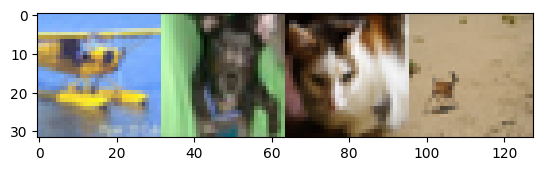

In [10]:
display_image(y1)

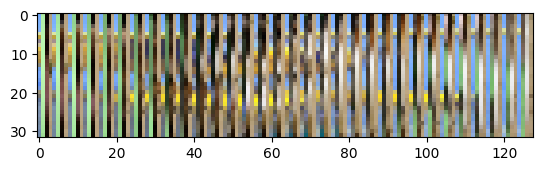

In [11]:
display_image(y2)

#### WTF!

- Well, when the shape is `[height, batch_size, width, channel]`, reshape fixes the rows to be `height` and then will fix the specific item from the batch, as it is the second dimension on the shape.

- When the shape is `[height, width, batch_size, channel]`, reshape fixes the rows to be `height` and then will fix a column from the images, and go ahead with all batches for that column. that's why images get interleaved.

This indicates issues:
- both chains "work" and the resulting tensors have the same shape
- mistakes on the code related to the tensor's shapes are under the radar
- weak point of these conventional operations: lack of stronger checks
- requires writing down all intermediate steps to debug the code
- most times it's not possible to visualize intermediate steps meaningfully



A few other problems:

- Some languages use 1-based indexing, and Python uses 0-based indexing

- Einops does not rely on axis numeration, so it is not affected by this.

### Tensor operations break the structure

`reshape` treats tensors as sequences

In [12]:
x = batch_X[0].transpose(1, 2, 0)
x.shape

(32, 32, 3)

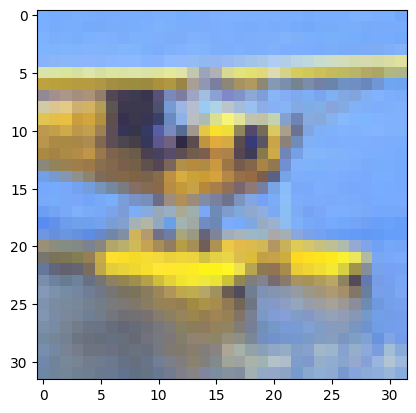

In [13]:
display_image(x)

(16, 64, 3)


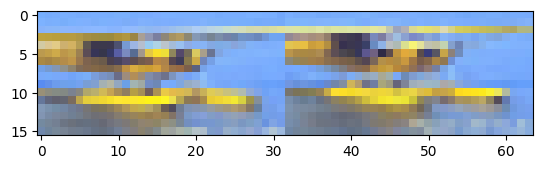

In [14]:
new_x = x.reshape(16, -1, 3)
print(new_x.shape)
display_image(new_x)

(32, 3, 32)
(16, 3, 64)


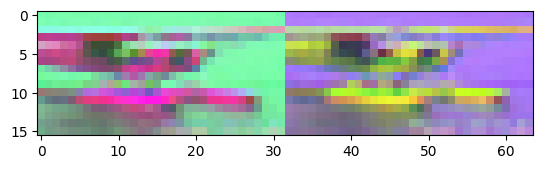

In [16]:
new_x = x.transpose(0, 2, 1)
print(new_x.shape)
new_x = new_x.reshape(16, 3, -1)
print(new_x.shape)
display_image(new_x.transpose(0, 2, 1))

(32, 3, 32)
(8, 3, 128)


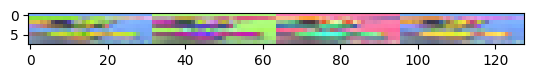

In [17]:
xx = x.transpose(0, 2, 1)
print(xx.shape)
xx = xx.reshape(8, 3, -1)
print(xx.shape)
display_image(xx.transpose(0, 2, 1))

(28, 32, 3)


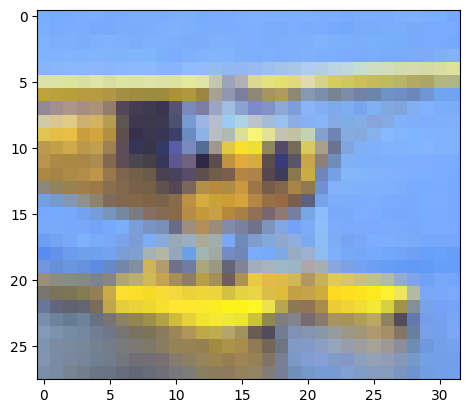

In [18]:
xx = x[:-4, :, :]
print(xx.shape)
display_image(xx)

(28, 3, 32)
(7, 3, 128)


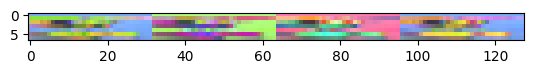

In [19]:
xx = xx.transpose(0, 2, 1)
print(xx.shape)
xx = xx.reshape(7, 3, -1)
print(xx.shape)
display_image(xx.transpose(0, 2, 1))

(7, 3, 128)
(16, 3, 56)


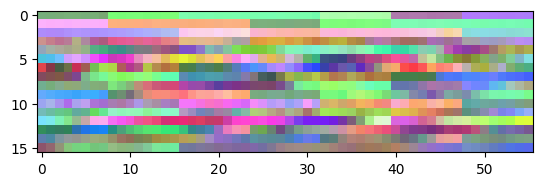

In [20]:
print(xx.shape)
xx = xx.reshape(16, 3, -1)
print(xx.shape)
display_image(xx.transpose(0, 2, 1))


**What a mess!**

## Using einops

In [22]:
! pip install einops


In [23]:
from einops import rearrange, reduce, repeat

In [25]:
batch_X.shape

(4, 3, 32, 32)

<class 'numpy.ndarray'> (32, 128, 3)


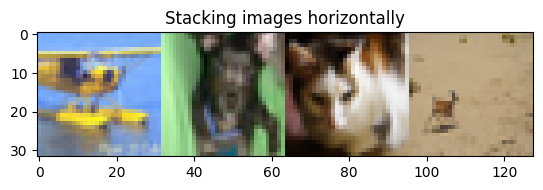

In [51]:
img_stack = rearrange(batch_X, 'b c h w -> h (b w) c')
print(type(img_stack), img_stack.shape)
plt.title('Stacking images horizontally')
display_image(img_stack)
plt.show()

<class 'numpy.ndarray'> (128, 32, 3)


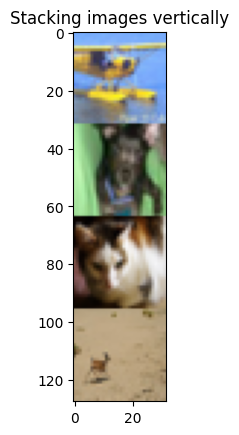

In [52]:
img_stack = rearrange(batch_X, 'b c h w -> (b h) w c')
print(type(img_stack), img_stack.shape)
plt.title('Stacking images vertically')
display_image(img_stack)
plt.show()

### Things still can go wrong.

<class 'numpy.ndarray'> (32, 128, 3)


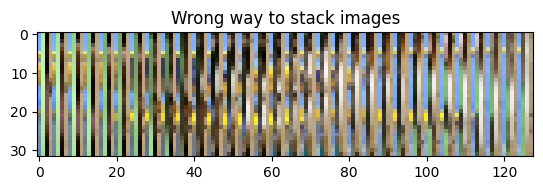

In [53]:
img_stack = rearrange(batch_X, 'b c h w -> h (w b) c')
print(type(img_stack), img_stack.shape)
plt.title('Wrong way to stack images')
display_image(img_stack)
plt.show()

**But it's easy to detect and fix**

Now it's more or less obvious that whenever you group the batch dimension with others, probably the batch should go first always

### Simple examples

<class 'numpy.ndarray'> (64, 64, 3)


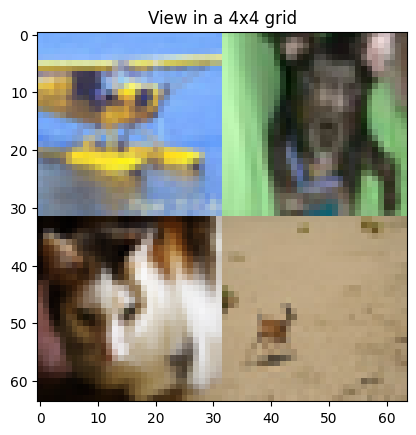

In [66]:
img_stack = rearrange(batch_X, '(b1 b2) c h w -> (b1 h) (b2 w) c', b1 = 2, b2 = 2)
print(type(img_stack), img_stack.shape)
plt.title('View in a 4x4 grid')
display_image(img_stack)
plt.show()

In [36]:
batch_X.shape

(4, 3, 32, 32)

<class 'numpy.ndarray'> (16, 16, 3)


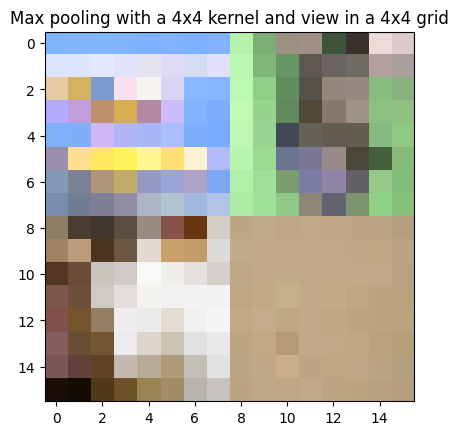

In [67]:
img_stack = reduce(batch_X, 'b c (h 4) (w 4) -> b c h w', 'max')
img_stack = rearrange(img_stack, '(b1 b2) c h w -> (b1 h) (b2 w) c', b1 = 2, b2 = 2)
print(type(img_stack), img_stack.shape)
plt.title('Max pooling with a 4x4 kernel and view in a 4x4 grid')
display_image(img_stack)
plt.show()

(3, 32, 32)


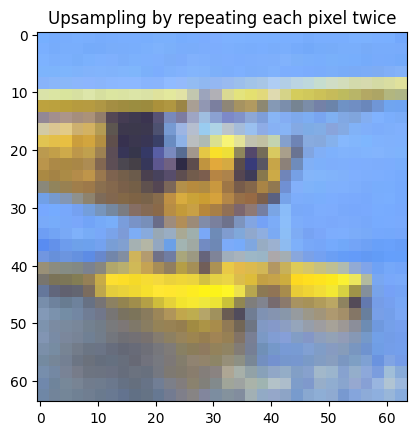

In [68]:
img = batch_X[0]
print(img.shape)
new_img = repeat(img, 'c h w -> (h 2) (w 2) c')
plt.title('Upsampling by repeating each pixel twice')
display_image(new_img)